In [1]:
# https://www.kaggle.com/kpriyanshu256/bert-fastai
# https://mlexplained.com/2019/05/13/a-tutorial-to-fine-tuning-bert-with-fast-ai/

In [2]:
! pip install transformers -q

In [3]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import csv
import random

from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel

from nltk.tokenize import TweetTokenizer
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [4]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [5]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(testing = False, model_name = "bert-base-cased", max_lr = 3e-5, epochs = 4, 
                use_fp16 = True, bs = 64, discriminative = False, max_seq_len = 64,)

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased",)

In [7]:
class FastAiTokenizer(BaseTokenizer):
    """wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int = 128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        # add special tokens and limit max length
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

# we need to wrap the above code within another Tokenizer to pass to the preprocessors
fastai_tokenizer = Tokenizer(tok_func = FastAiTokenizer(tokenizer, max_seq_len = config.max_seq_len), pre_rules = [], post_rules = [])

In [8]:
# construct a fastai Vocab object from the bert vocabulary (a dictionary mapping from wordpiece to id)
fastai_vocab = Vocab(list(tokenizer.vocab.keys()))

In [9]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

label_cols = list(set(train['target']))

In [10]:
twt = TweetTokenizer(strip_handles = True)

def tweets(r):
    s = ' '.join(twt.tokenize(r['text']))
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'https\S+', '', s)    
    return s

train['ptext'] = train.apply(tweets, axis = 1)
test['ptext'] = test.apply(tweets, axis = 1)

X_train, X_val = train_test_split(train,test_size = 0.3)

In [11]:
# read the data into a databunch ( initializing a TokenizerProcessor and a NumericalizeProcessor with the wordpiece tokenizer and BERT vocabulary)
# include_bos=False and include_eos=False: fastai adds its own bos and eos tokens by default which interferes with the [CLS] and [SEP] tokens added by BERT
databunch = TextDataBunch.from_df(".", train_df = X_train, valid_df = X_val,test_df = test,tokenizer = fastai_tokenizer, vocab = fastai_vocab,
     include_bos = False, include_eos = False, text_cols="ptext", label_cols='target', bs = config.bs,
     collate_fn = partial(pad_collate, pad_first = False),)

In [12]:
# read the data into a databunch using your own TokenizerProcessor and NumericalizeProcessor
# should return same results as the previous code

class AutoTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class AutoNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_auto_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    remove sos/eos tokens since we add that ourselves in the tokenizer
    use a custom vocabulary to match the numericalization with the original BERT model
    """
    return [AutoTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]


class AutoDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_auto_processor)
        processor = get_auto_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: 
          classes = label_cols
        
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor), TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)

        if test_df is not None: 
          src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

    
# read the data into a databunch 
# include_bos=False and include_eos=False: fastai adds its own bos and eos tokens by default which interferes with the [CLS] and [SEP] tokens added by BERT
#databunch = AutoDataBunch.from_df(".", train_df = X_train, valid_df = X_val,test_df = test,tokenizer = fastai_tokenizer,vocab = fastai_vocab,
#                                  text_cols = "ptext",label_cols = 'target',bs = config.bs,collate_fn = partial(pad_collate, pad_first = False, pad_idx = 0),)

In [13]:
def softmax(v):
  e = torch.exp(v)
  s = torch.sum(e, dim=0)
  return e/s

In [14]:
class BertForSequenceClassification(BertPreTrainedModel):
    
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        outputs = self.bert(input_ids,attention_mask=attention_mask,token_type_ids=token_type_ids,position_ids=position_ids,
                            head_mask=head_mask,inputs_embeds=inputs_embeds)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        
        logits = self.classifier(pooled_output)
        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return softmax(outputs[0])  # (loss), logits, (hidden_states), (attentions)

In [15]:
auto_model = BertForSequenceClassification.from_pretrained(config.model_name, num_labels = len(set(train['target'])))

In [16]:
learner = Learner(databunch, auto_model, metrics=[accuracy,error_rate])
learner.callbacks.append(ShowGraph(learner))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 2.29E-05


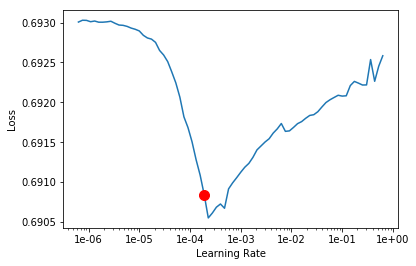

In [17]:
# learning rate finder
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.683181,0.682401,0.779334,0.220665,00:19
1,0.679802,0.680495,0.806042,0.193958,00:21


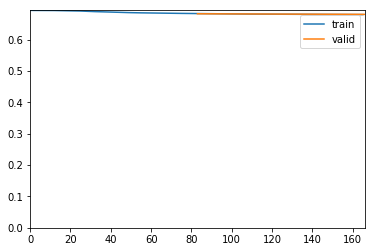

In [18]:
learner.fit_one_cycle(2, slice(1e-4))

In [19]:
learner.save('bert')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 7.59E-08


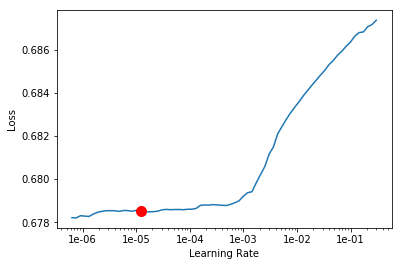

In [20]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.678594,0.680346,0.809982,0.190018,00:20
1,0.678618,0.680240,0.809982,0.190018,00:20
2,0.678541,0.680231,0.809545,0.190455,00:19


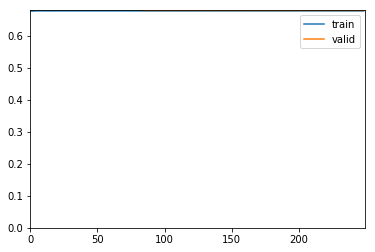

In [21]:
# train the model
learner.fit_one_cycle(3, slice(1e-6))

In [22]:
# learner.fit_one_cycle(5, slice(5e-8))
# learner.load('model')

In [23]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [24]:
val_preds = get_preds_as_nparray(DatasetType.Valid)

In [25]:
test_preds = get_preds_as_nparray(DatasetType.Test)
preds = []

In [26]:
vpreds = []
for i in val_preds:
    vpreds.append(np.argmax(i))

In [27]:
for i in test_preds:
    preds.append(np.argmax(i))

In [28]:
print(classification_report(X_val['target'], vpreds))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1318
           1       0.79      0.75      0.77       966

    accuracy                           0.81      2284
   macro avg       0.81      0.80      0.80      2284
weighted avg       0.81      0.81      0.81      2284



In [29]:
submission['target'] = preds
submission.to_csv('submission.csv', index=False)